# Домашнее задание №2: Датасет Iris, PyTorch

# 1) Используя встроенные классы

## Импорт библиотек

In [198]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

## Загрузка и подготовка данных

In [199]:
data = load_iris()
features = data["data"].astype(np.float32)
labels = data["target"].astype(np.int64)

# train/test split 75/25 с одинаковым распределением классов
X_tr, X_te, y_tr, y_te = train_test_split(
    features, labels,
    test_size=0.25,
    stratify=labels,
    random_state=999
)

## Класс Dataset + DataLoader

In [200]:
class IrisData(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X)
        self.y = torch.tensor(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.y[index]

train_ds = IrisData(X_tr, y_tr)
test_ds  = IrisData(X_te, y_te)

batch = 16

val_size = int(0.2 * len(train_ds))
train_size = len(train_ds) - val_size

train_ds, val_ds = random_split(train_ds, [train_size, val_size],
                                generator=torch.Generator().manual_seed(999))

print("Размеры train, val и test:", len(train_ds), len(val_ds), len(test_ds))

train_loader = DataLoader(train_ds, batch_size=batch, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=batch, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=batch, shuffle=False)


Размеры train, val и test: 90 22 38


## Определение нейронной сети

In [201]:
class IrisNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(4, 16)
        self.layer2 = nn.Linear(16, 3)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        return self.layer2(x)

model = IrisNet()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


## Обучение

In [202]:
epochs = 50
training_loss = []
training_accuracy = []
val_loss = []
val_accuracy = []

for ep in range(epochs):
    # --- Training ---
    model.train()
    total_ep_loss = 0.0
    correct = 0
    total = 0

    for xb, yb in train_loader:
        optimizer.zero_grad()
        outputs = model(xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()

        total_ep_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        correct += (preds == yb).sum().item()
        total += yb.size(0)

    training_loss.append(total_ep_loss)
    training_accuracy.append(correct / total)

    model.eval()
    val_ep_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for xb, yb in val_loader:
            outputs = model(xb)
            loss = criterion(outputs, yb)
            val_ep_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            val_correct += (preds == yb).sum().item()
            val_total += yb.size(0)

    val_loss.append(val_ep_loss)
    val_accuracy.append(val_correct / val_total)

    print(f"Epoch {ep+1}/{epochs}: "
          f"Train Loss={total_ep_loss:.4f}, Train Acc={training_accuracy[-1]:.4f}, "
          f"Val Loss={val_ep_loss:.4f}, Val Acc={val_accuracy[-1]:.4f}")

Epoch 1/50: Train Loss=6.9634, Train Acc=0.2889, Val Loss=2.0835, Val Acc=0.2273
Epoch 2/50: Train Loss=5.4485, Train Acc=0.5333, Val Loss=1.6668, Val Acc=0.6364
Epoch 3/50: Train Loss=4.4755, Train Acc=0.6778, Val Loss=1.2298, Val Acc=0.7727
Epoch 4/50: Train Loss=3.7147, Train Acc=0.6333, Val Loss=1.0695, Val Acc=0.9091
Epoch 5/50: Train Loss=3.2747, Train Acc=0.8333, Val Loss=0.9492, Val Acc=1.0000
Epoch 6/50: Train Loss=2.9676, Train Acc=0.9556, Val Loss=0.8704, Val Acc=0.9545
Epoch 7/50: Train Loss=2.7349, Train Acc=0.8889, Val Loss=0.7999, Val Acc=1.0000
Epoch 8/50: Train Loss=2.6045, Train Acc=0.9000, Val Loss=0.7843, Val Acc=0.8636
Epoch 9/50: Train Loss=2.3493, Train Acc=0.9667, Val Loss=0.6803, Val Acc=1.0000
Epoch 10/50: Train Loss=2.2831, Train Acc=0.8556, Val Loss=0.6470, Val Acc=1.0000
Epoch 11/50: Train Loss=2.2040, Train Acc=0.9444, Val Loss=0.6865, Val Acc=0.8636
Epoch 12/50: Train Loss=2.1741, Train Acc=0.9222, Val Loss=0.5827, Val Acc=1.0000
Epoch 13/50: Train Loss=1

## Тестирование модели

In [203]:
model.eval()
all_preds = []
all_true = []

def class_accuracy(y_true, y_pred, num_classes=3):
    """
    Возвращает accuracy по каждому классу
    y_true, y_pred: списки или тензоры с метками
    num_classes: количество классов
    """
    y_true = torch.tensor(y_true)
    y_pred = torch.tensor(y_pred)
    acc_per_class = []
    
    for cls in range(num_classes):
        idx = (y_true == cls)
        if idx.sum() == 0:
            acc = float('nan')
        else:
            acc = (y_pred[idx] == y_true[idx]).sum().item() / idx.sum().item()
        acc_per_class.append(acc)
    
    return acc_per_class

with torch.no_grad():
    for xb, yb in test_loader:
        logits = model(xb)
        pred = torch.argmax(logits, dim=1)
        all_preds.extend(pred.tolist())
        all_true.extend(yb.tolist())

print("Classification report:\n")
print(classification_report(all_true, all_preds))

print("Confusion matrix:\n")
print(confusion_matrix(all_true, all_preds))

acc_per_class = class_accuracy(all_true, all_preds, num_classes=3)
for cls_idx, acc in enumerate(acc_per_class):
    print(f"Accuracy для класса {cls_idx}: {acc:.4f}")


Classification report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       1.00      1.00      1.00        12
           2       1.00      1.00      1.00        13

    accuracy                           1.00        38
   macro avg       1.00      1.00      1.00        38
weighted avg       1.00      1.00      1.00        38

Confusion matrix:

[[13  0  0]
 [ 0 12  0]
 [ 0  0 13]]
Accuracy для класса 0: 1.0000
Accuracy для класса 1: 1.0000
Accuracy для класса 2: 1.0000


## Графики для анализа

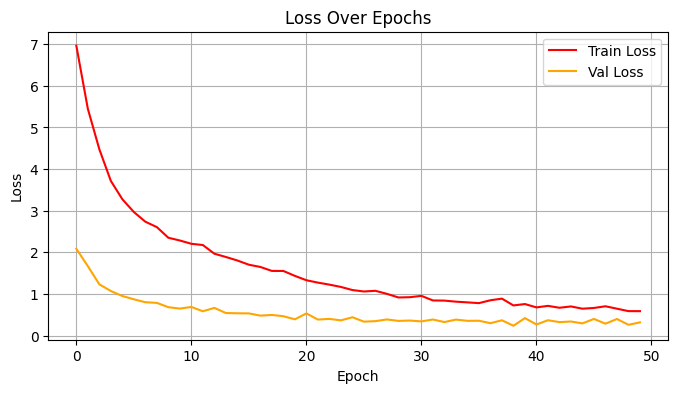

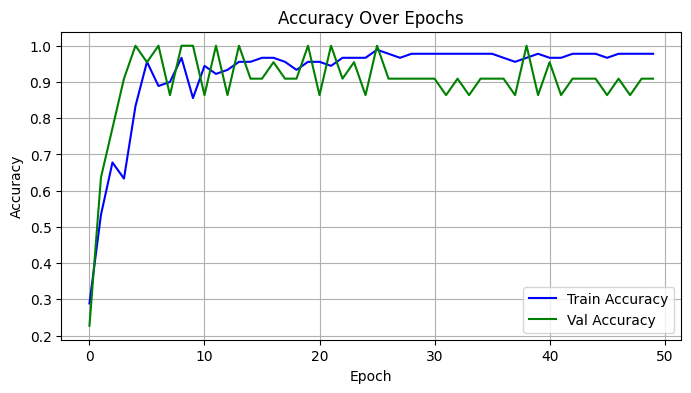

In [204]:
plt.figure(figsize=(8,4))
plt.plot(training_loss, label='Train Loss', color='red')
plt.plot(val_loss, label='Val Loss', color='orange')
plt.title("Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(8,4))
plt.plot(training_accuracy, label='Train Accuracy', color='blue')
plt.plot(val_accuracy, label='Val Accuracy', color='green')
plt.title("Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()
plt.show()


# 2) Используя свои классы

## Импорт библиотек

In [205]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import random

## Загрузка и подготовка данных

In [206]:
data = load_iris()
features = torch.tensor(data["data"], dtype=torch.float32)
labels = torch.tensor(data["target"], dtype=torch.long)

# Train/test split
X_tr, X_te, y_tr, y_te = train_test_split(
    features, labels,
    test_size=0.25,
    stratify=labels,
    random_state=999
)

# Train/val split вручную (80/20 от тренировочного набора)
val_size = int(0.2 * X_tr.shape[0])
train_size = X_tr.shape[0] - val_size
X_train, y_train = X_tr[:train_size], y_tr[:train_size]
X_val, y_val     = X_tr[train_size:], y_tr[train_size:]
X_test, y_test   = X_te, y_te

batch_size = 16

## Класс Dataset + DataLoader

In [207]:
class MyDataset:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.length = X.shape[0]

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class MyDataLoader:
    def __init__(self, dataset, batch_size=16, shuffle=True):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle

    def __iter__(self):
        self.idx_list = list(range(len(self.dataset)))
        if self.shuffle:
            random.shuffle(self.idx_list)
        self.current_idx = 0
        return self

    def __next__(self):
        if self.current_idx >= len(self.idx_list):
            raise StopIteration

        batch_idx = self.idx_list[self.current_idx:self.current_idx + self.batch_size]
        self.current_idx += self.batch_size

        X_batch = torch.stack([self.dataset[i][0] for i in batch_idx])
        y_batch = torch.stack([self.dataset[i][1] for i in batch_idx])
        return X_batch, y_batch

    def __len__(self):
        return (len(self.dataset) + self.batch_size - 1) // self.batch_size

# Создаём свои датасеты и загрузчики
train_dataset = MyDataset(X_train, y_train)
val_dataset   = MyDataset(X_val, y_val)
test_dataset  = MyDataset(X_test, y_test)
print("Размеры train, val, test:", len(train_dataset), len(val_dataset), len(test_dataset))

train_loader = MyDataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = MyDataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = MyDataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Размеры train, val, test: 90 22 38


## Определение нейронной сети

In [208]:
class SimpleIrisNet(nn.Module):
    def __init__(self, inputDim=4, hiddenDim=32, outputDim=3):
        super().__init__()
        self.linear1 = nn.Linear(inputDim, hiddenDim)
        self.batchNorm1 = nn.BatchNorm1d(hiddenDim)
        self.linear2 = nn.Linear(hiddenDim, outputDim)

    def forward(self, x):
        x = self.linear1(x)
        x = self.batchNorm1(x)
        x = F.relu(x)
        x = self.linear2(x)
        return x

model = SimpleIrisNet()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

## Обучение

In [209]:
epochs = 50
train_loss_list, train_acc_list = [], []
val_loss_list, val_acc_list = [], []

for ep in range(epochs):
    # --- Training ---
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        correct += (preds == y_batch).sum().item()
        total += y_batch.size(0)

    train_loss_list.append(total_loss)
    train_acc_list.append(correct / total)

    # --- Validation ---
    model.eval()
    with torch.no_grad():
        val_outputs = []
        val_loss = 0
        val_correct = 0
        val_total = 0

        for X_batch, y_batch in val_loader:
            outputs = model(X_batch)
            val_loss += criterion(outputs, y_batch).item()
            preds = torch.argmax(outputs, dim=1)
            val_correct += (preds == y_batch).sum().item()
            val_total += y_batch.size(0)

    val_loss_list.append(val_loss)
    val_acc_list.append(val_correct / val_total)

    print(f"Epoch {ep+1}/{epochs}: "
          f"Train Loss={total_loss:.4f}, Train Acc={train_acc_list[-1]:.4f}, "
          f"Val Loss={val_loss:.4f}, Val Acc={val_acc_list[-1]:.4f}")

Epoch 1/50: Train Loss=5.0861, Train Acc=0.6556, Val Loss=2.0325, Val Acc=0.5000
Epoch 2/50: Train Loss=2.9999, Train Acc=0.8222, Val Loss=1.1443, Val Acc=0.6364
Epoch 3/50: Train Loss=2.4520, Train Acc=0.8111, Val Loss=1.0512, Val Acc=0.6818
Epoch 4/50: Train Loss=2.0074, Train Acc=0.8333, Val Loss=1.0199, Val Acc=0.6818
Epoch 5/50: Train Loss=2.0073, Train Acc=0.8444, Val Loss=0.9073, Val Acc=0.6818
Epoch 6/50: Train Loss=1.9764, Train Acc=0.8667, Val Loss=0.6968, Val Acc=0.8182
Epoch 7/50: Train Loss=1.9656, Train Acc=0.8333, Val Loss=0.6192, Val Acc=0.8182
Epoch 8/50: Train Loss=1.5742, Train Acc=0.8778, Val Loss=0.5350, Val Acc=0.9091
Epoch 9/50: Train Loss=1.8588, Train Acc=0.8667, Val Loss=0.5213, Val Acc=0.9091
Epoch 10/50: Train Loss=1.6689, Train Acc=0.8889, Val Loss=0.4771, Val Acc=0.9545
Epoch 11/50: Train Loss=1.6844, Train Acc=0.8444, Val Loss=0.4137, Val Acc=0.9545
Epoch 12/50: Train Loss=2.1308, Train Acc=0.8889, Val Loss=0.3647, Val Acc=1.0000
Epoch 13/50: Train Loss=1

## Тестирование

In [210]:
model.eval()
all_preds = []
all_true = []

def class_accuracy(y_true, y_pred, num_classes=3):
    """
    Возвращает accuracy по каждому классу
    y_true, y_pred: списки или тензоры с метками
    num_classes: количество классов
    """
    y_true = torch.tensor(y_true)
    y_pred = torch.tensor(y_pred)
    acc_per_class = []
    
    for cls in range(num_classes):
        idx = (y_true == cls)
        if idx.sum() == 0:
            acc = float('nan')
        else:
            acc = (y_pred[idx] == y_true[idx]).sum().item() / idx.sum().item()
        acc_per_class.append(acc)
    
    return acc_per_class


with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.tolist())
        all_true.extend(y_batch.tolist())

print("Classification report:\n")
print(classification_report(all_true, all_preds))

print("Confusion matrix:\n")
print(confusion_matrix(all_true, all_preds))

acc_per_class = class_accuracy(all_true, all_preds, num_classes=3)
for cls_idx, acc in enumerate(acc_per_class):
    print(f"Accuracy для класса {cls_idx}: {acc:.4f}")

Classification report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       0.92      0.92      0.92        12
           2       0.92      0.92      0.92        13

    accuracy                           0.95        38
   macro avg       0.95      0.95      0.95        38
weighted avg       0.95      0.95      0.95        38

Confusion matrix:

[[13  0  0]
 [ 0 11  1]
 [ 0  1 12]]
Accuracy для класса 0: 1.0000
Accuracy для класса 1: 0.9167
Accuracy для класса 2: 0.9231


## Графики для анализа

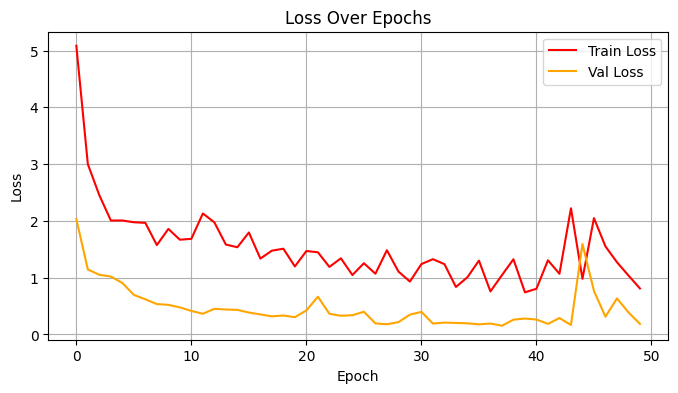

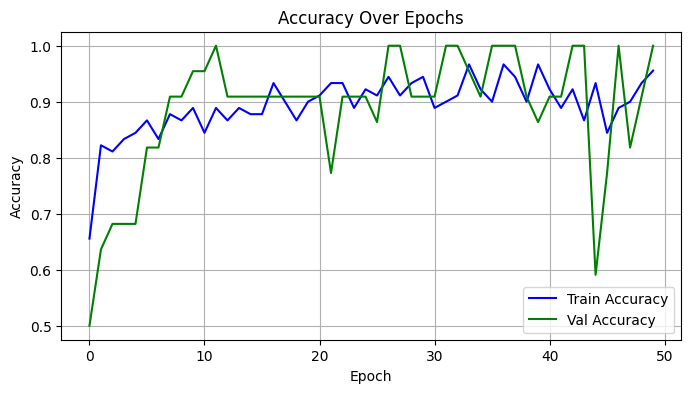

In [211]:
plt.figure(figsize=(8,4))
plt.plot(train_loss_list, label='Train Loss', color='red')
plt.plot(val_loss_list, label='Val Loss', color='orange')
plt.title("Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(8,4))
plt.plot(train_acc_list, label='Train Accuracy', color='blue')
plt.plot(val_acc_list, label='Val Accuracy', color='green')
plt.title("Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()
plt.show()